In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


Description of dataset from https://www.kaggle.com/roshansharma/online-shoppers-intention

The dataset consists of feature vectors belonging to 12,330 sessions. The dataset was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.

The 'Revenue' attribute can be used as the class label.

In [2]:
# Load the data from CSV
# Original data source: https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#

data = pd.read_csv("online_shoppers_intention.csv") 
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
# Describe
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Source for below feature engineering - https://www.kaggle.com/kageyama/lgbm-online-shopper-s-eda-and-classification


In [4]:
# Check for nulls. Source: https://www.kaggle.com/kageyama/lgbm-online-shopper-s-eda-and-classification
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

missing_data(data)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64,object,bool,bool


In [5]:
# Inspect the columns for comparison later in the notebook
data.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [6]:
# Feature engineering:
# Categorical data - split it out
data['SpecialDay'] = data['SpecialDay'].astype('object')
data['OperatingSystems'] = data['OperatingSystems'].astype('object')
data['Browser'] = data['Browser'].astype('object')
data['Region'] = data['Region'].astype('object')
data['TrafficType'] = data['TrafficType'].astype('object')
data.columns # Note, this did not change the columns, but will matter later

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

count     12330
unique        2
top       False
freq      10422
Name: Revenue, dtype: object
Revenue
False    10422
True      1908
Name: VisitorType, dtype: int64


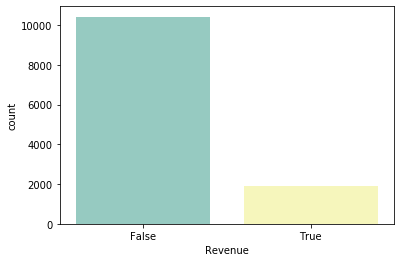

In [7]:
# Inspect the classifier, Revenue
print(data.Revenue.describe())

# Appears to be a boolean, True or False
print(data.groupby("Revenue").count().VisitorType)

sns.countplot(data['Revenue'], palette='Set3')

<Figure size 432x288 with 0 Axes>

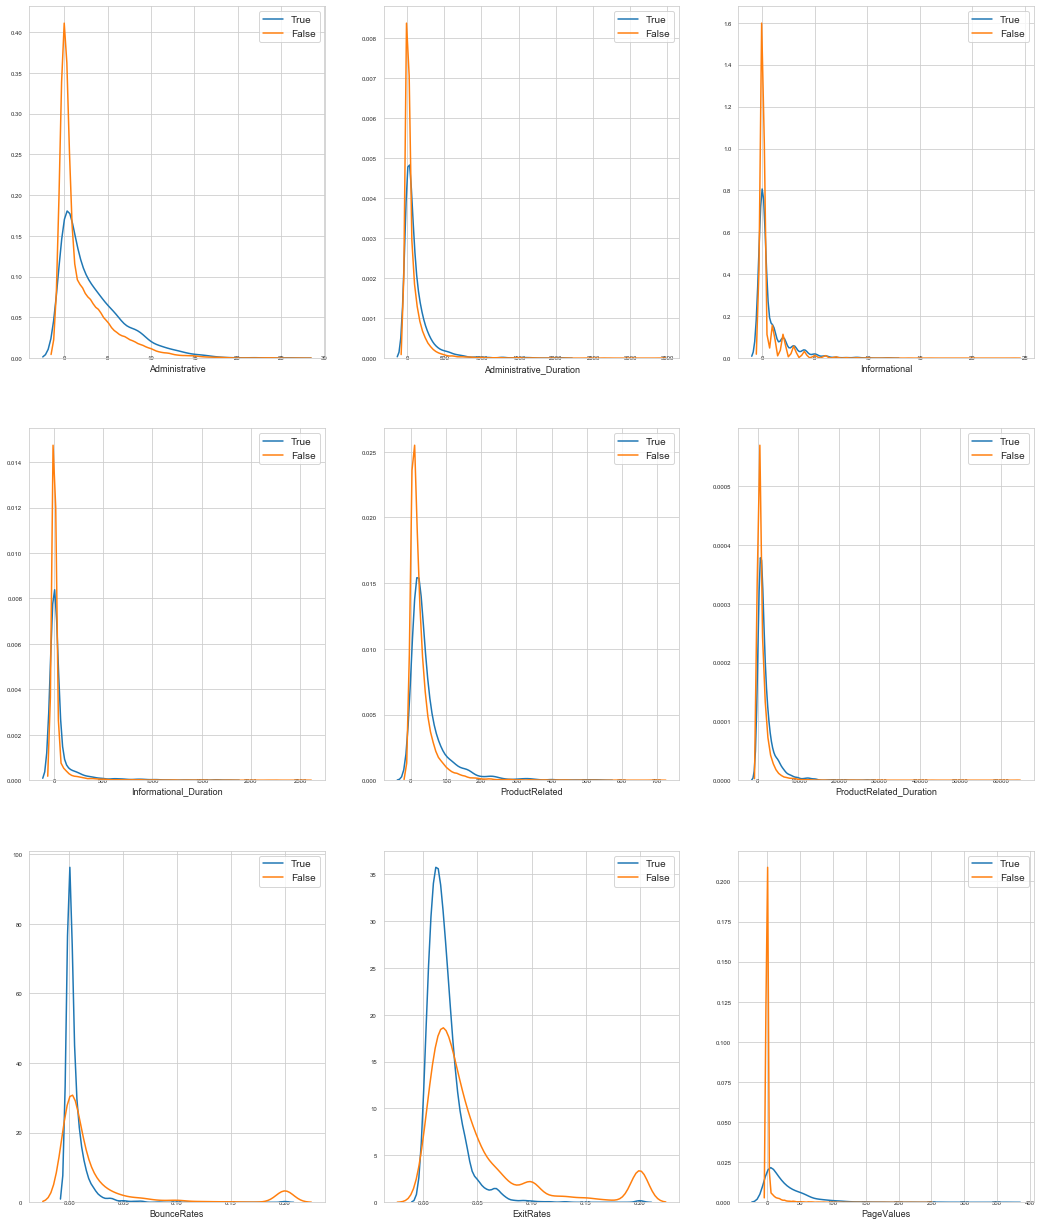

In [8]:
# Look at the feature distribution and shapes

def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(3,3,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();
    
    
t0 = data.loc[data['Revenue'] == True]
t1 = data.loc[data['Revenue'] == False]
features = data.columns.values[0:9]
plot_feature_distribution(t0, t1, 'True', 'False', features)

In [9]:
# Perform one-hot encoding on all columns EXCEPT those that are designated as categorical columns!
data = pd.get_dummies(data,columns=['SpecialDay', 'Month', 'OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend'])

# Tada
data.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Revenue', 'SpecialDay_0.0',
       'SpecialDay_0.2', 'SpecialDay_0.4', 'SpecialDay_0.6', 'SpecialDay_0.8',
       'SpecialDay_1.0', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'OperatingSystems_8',
       'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10',
       'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_1', 'Tr

In [10]:
# Prepare for k-fold, bootstrap, and test/train split
y = data["Revenue"]
data = data.drop(columns=["Revenue"])



In [11]:
X_train,X_test,y_train,y_test = train_test_split(data,y)

y_train *= 1
y_test *= 1

y_train

1828     0
6958     0
10639    0
5000     0
12106    0
        ..
8464     0
11900    0
11524    0
11043    0
9060     0
Name: Revenue, Length: 9247, dtype: int64

## Notes
The dataset appears to be very imbalanced with 10422 v 1908 non-consumers vs consumers.

This means that accuracy will not be a good metrics

This also sets the accuracy baseline to 10422/12330 = 0.84

Source for next steps: https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html

1. Use a metric *besides* accuracy:
    - Precision/Specificity: how many selected instances are relevant.
    - Recall/Sensitivity: how many relevant instances are selected.
    - F1 score: harmonic mean of precision and recall.
    - MCC: correlation coefficient between the observed and predicted binary classifications.
    - AUC: relation between true-positive rate and false positive rate.
    
2. Use K-fold Cross-Validation
3. Bootstrap and resample


In [13]:
# K-fold cross validation
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

# create model function
def create_model(optimizer='adam', dropout=0.1):
    model = Sequential()
    model.add(Dense(64, input_shape=(80,), activation=("relu")))
    model.add(Dense(2, activation=("softmax")))
    model.add(Dropout(dropout))
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    return model

# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_model, verbose=1)

# Set grid search parameters:
optimizers = ['adam', SGD()]
epochs = [10]
dropout = [0.1]
    

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, epochs=epochs, dropout=dropout)


# Use it!
grid = GridSearchCV(estimator=neural_network, cv=folds.split(X_train, y_train), param_grid=hyperparameters)

grid_search_fit = grid.fit(X_train, y_train)

def report_results(model, X, y):
    pred = model.predict(X)        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result


Epoch 1/10
8784/8784 [==============================] - 1s 83us/step - loss: nan - accuracy: 0.8428
Epoch 2/10
8784/8784 [==============================] - 1s 60us/step - loss: nan - accuracy: 0.8444
Epoch 3/10
8784/8784 [==============================] - 1s 62us/step - loss: nan - accuracy: 0.8444: 0s - loss: nan - accuracy: 0
Epoch 4/10
8784/8784 [==============================] - 1s 63us/step - loss: nan - accuracy: 0.8444
Epoch 5/10
8784/8784 [==============================] - 1s 66us/step - loss: nan - accuracy: 0.8444
Epoch 6/10
8784/8784 [==============================] - 1s 65us/step - loss: nan - accuracy: 0.8444
Epoch 7/10
8784/8784 [==============================] - 1s 68us/step - loss: nan - accuracy: 0.8444
Epoch 8/10
8784/8784 [==============================] - 1s 66us/step - loss: nan - accuracy: 0.8444
Epoch 9/10
8784/8784 [==============================] - 1s 62us/step - loss: nan - accuracy: 0.8444
Epoch 10/10
463/463 [==============================] - 0s 121us/step
E

In [14]:
test_results = report_results(grid_search_fit.best_estimator_, X_test, y_test)
print(test_results)

3083/3083 [==============================] - 0s 35us/step
{'f1': 0.0, 'acc': 0.8478754459941615, 'precision': 0.0, 'recall': 0.0}


/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
y_train.head()

2182     0
11795    0
1613     0
3112     0
4790     1
Name: Revenue, dtype: int64

In [12]:
# Oversample implementation as the above implementation yielded the expected 0.84 baseline accuracy and therefore no "True" conversions
from imblearn.over_sampling import  SMOTE, ADASYN, RandomOverSampler
# RandomOverSampler
  # With over-sampling methods, the number of samples in a class
  # should be greater or equal to the original number of samples.
sampler = RandomOverSampler()
X_rs, y_rs = sampler.fit_sample(X_train, y_train)
print('RandomOverSampler {}'.format(Counter(y_rs)))

RandomOverSampler Counter({0: 7820, 1: 7820})


In [13]:
y_rs

0        0
1        0
2        0
3        0
4        0
        ..
15635    1
15636    1
15637    1
15638    1
15639    1
Name: Revenue, Length: 15640, dtype: int64

In [15]:

# Model idea from: https://www.kaggle.com/liyapranay/prediction-using-svm-logreg-rf-neuralnetwork
model = Sequential()
model.add(Dense(units = 128, activation = 'relu', input_dim = 80))
model.add(Dropout(0.20))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(X_rs, y_rs, batch_size=32, epochs=100, verbose=1, validation_split=0.2)

Train on 12512 samples, validate on 3128 samples
Epoch 1/100
12512/12512 [==============================] - 2s 132us/step - loss: 6.5134 - accuracy: 0.5738 - val_loss: 1.2666 - val_accuracy: 0.0515
Epoch 2/100
12512/12512 [==============================] - 1s 104us/step - loss: 1.2145 - accuracy: 0.6235 - val_loss: 0.7481 - val_accuracy: 0.2494
Epoch 3/100
12512/12512 [==============================] - 1s 101us/step - loss: 0.7097 - accuracy: 0.6634 - val_loss: 0.8555 - val_accuracy: 0.0975
Epoch 4/100
12512/12512 [==============================] - 1s 102us/step - loss: 0.6302 - accuracy: 0.6806 - val_loss: 0.8267 - val_accuracy: 0.1471
Epoch 5/100
12512/12512 [==============================] - 1s 101us/step - loss: 0.5796 - accuracy: 0.7090 - val_loss: 0.9341 - val_accuracy: 0.1586
Epoch 6/100
12512/12512 [==============================] - 1s 108us/step - loss: 0.5576 - accuracy: 0.7211 - val_loss: 0.7392 - val_accuracy: 0.3194
Epoch 7/100
12512/12512 [==============================] 

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test score:", score[0])
print('Test accuracy:', score[1])

# Beat the baseline!!!

3083/3083 [==============================] - 0s 44us/step
Test score: 0.3663294530711389
Test accuracy: 0.8631203174591064


In [19]:
# Now to test the predictions
def report_results(model, X, y, pred):
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

y_pred = model.predict(X_test)
y_pred *= y_pred.astype(int)
print(y_pred)

test_results = report_results(model, X_test, y_test, y_pred)
print(test_results)

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
{'f1': 0.008281573498964804, 'acc': 0.8446318520921181, 'precision': 1.0, 'recall': 0.004158004158004158}
[[2602    0]
 [ 479    2]]


The f1 and recall scores indicate that this model is still not predicting as we want, and the confusion matrix verifies that, with the extremely high number of False Negatives (interpretation source: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) 

Next steps for this data set will be to rewind, look at:

- normalizing the features
- better undersampling/oversampling methods
- feature engineering starting with PCA